In [1]:
import pandas as pd
import matplotlib.pyplot as plot
import numpy as np

Source data:
Table 20 from: https://www.ons.gov.uk/peoplepopulationandcommunity/personalandhouseholdfinances/incomeandwealth/datasets/theeffectsoftaxesandbenefitsonhouseholdincomefinancialyearending2014

Set some parameters

In [2]:
# Total population
popT=65e6
# Population in quintile
popQ = popT / 5
# 
decLab='Decile (Equivalised Original Household Income)'

Read in the data

In [3]:
data=pd.read_excel('data/data.xlsx',sheet_name='Deciles')
# Print the column names
data.columns

Index(['Decile', 'OriginalIncomeEqMin', 'OriginalIncomeEqMax', 'Nindividuals',
       'Nhouseholds', 'OriginalIncome', 'OriginalIncomeEq', 'DirectBenefits',
       'GrossIncome', 'GrossIncomeEq', 'DirectTax', 'DisposableIncome',
       'DisposableIncomeEq', 'IndirectTax', 'PostTaxIncome', 'PostTaxIncomeEq',
       'BenefitsInKind', 'FinalIncome', 'FinalIncomeEq'],
      dtype='object')

In [4]:
decile=data['Decile']
nHouseholds=data['Nhouseholds']
origIncome=data['OriginalIncome']
origIncomeEq=data['OriginalIncomeEq']
dirBen=data['DirectBenefits']
grossIncome=data['GrossIncome']
dirTax=data['DirectTax']
dispIncome=data['DisposableIncome']
indirTax=data['IndirectTax']
postIncome=data['PostTaxIncome']
kindBen=data['BenefitsInKind']
finalIncome=data['FinalIncome']
nEquiv=data['OriginalIncome']/data['OriginalIncomeEq']

##### Quick look at data

Text(0,0.5,'avg £ per decile')

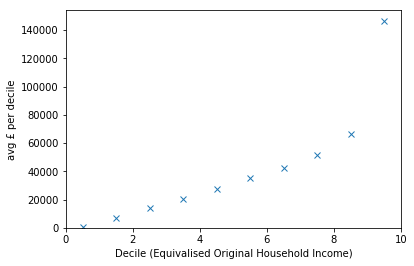

In [5]:
plot.plot(data['Decile']-0.5,data['OriginalIncomeEq'],'x')
plot.xlim(0,10)
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')

Text(0,0.5,'avg £ per decile')

/Applications/anaconda3/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


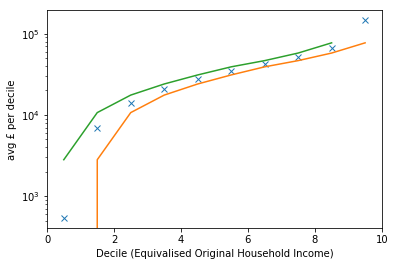

In [6]:
plot.plot(data['Decile']-0.5,data['OriginalIncomeEq'],'x')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMin'],'-')
plot.plot(data['Decile']-0.5,data['OriginalIncomeEqMax'],'-')
plot.yscale('log')
plot.xlim(0,10)
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')

### Model the distribution (basic)

Assume a linear income distribution ($Y$) vs ranking ($n$): $Y(n) = Y_0 + an$, with $Y(N)=Y_1$ and $\Delta Y(n)=Y(n)-Y_1$.


In [7]:
y0 = np.array(data['OriginalIncomeEqMin'])
y1 = np.array(data['OriginalIncomeEqMax'])
ybar = np.array(data['OriginalIncomeEq'])

# find the gradient in each decile
# where no max (top decile, use the mean as the mid-point
model_a=np.where(np.isfinite(y1),(y1-y0),(ybar-y0)*2)

# adjust for zero-income
# Find the gradient which gives the same mean in the bottom decile 
n_zero=1-(2*ybar[0]/y1[0])
model_a[0]=y1[0]/(1-n_zero)
# adjust the bottom limit so the model works
y0[0]=y1[0]-model_a[0]
print(len(y0),len(model_a))
# define the model function
def model(n,model=model_a,y0=y0,nEquiv=nEquiv,Eq=True):
    # n is in the range 0-1 over full population
    # convert to decile
    if np.isscalar(n):
        q=np.min([9,int(np.floor(n*10))])
    else:
        q = np.floor(n*10).astype(int)
    # calculate the modelled earnings
    mody=np.maximum(0,y0[q] + model_a[q]*(10*n-q))
    # convert to full household income from equivalised household income
#     print('n',n,len(n))
#     print('q',q,len(q))
#     print('y0',mody,len(y0))
#     print('model_a',model_a,len(model_a))
#     print('mody',mody,len(mody))
    if not Eq:
#         print('mody',mody,'nEquiv',nEquiv)
        mody = mody * nEquiv[q]
    return(mody)

10 10


### Sanity check
Check that the model looks sensible - plot the gradient across each decile as a sanit check

Text(0,0.5,'gradient over decile (£/dec)')

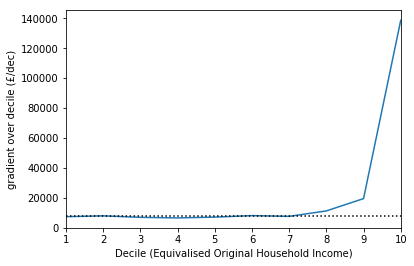

In [8]:
plot.plot(decile,model_a)
plot.axhline(np.mean(model_a[1:-2]),c='k',ls=':')
plot.xlabel(decLab)
plot.xlim(1,10)
plot.ylabel('gradient over decile (£/dec)')

As expected, the gradient is roughly constant, increasing at the highest incomes

### Test model
test the model and compare with the publised deciles and means

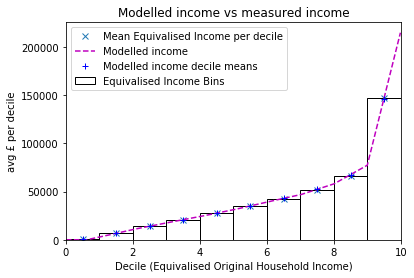

In [9]:
plot.plot(decile-0.5,data['OriginalIncomeEq'],'x',label='Mean Equivalised Income per decile')
plot.bar(decile-0.5,origIncomeEq,width=1,ls='-',fc='m',fill=None,label='Equivalised Income Bins')
# plot.plot(decile-1,data['OriginalIncomeEqMin'],'m+')
# plot.plot(decile,data['OriginalIncomeEqMax'],'m+')

narr=np.arange(0,1,0.001)
yarr=np.array(model(narr))

origEqMod=np.zeros_like(origIncome)
for q in np.arange(1,11):
    ind=np.where((narr<q/10)&(narr>=(q-1)/10))
    yind=yarr[ind]
#     print(q,yarr[ind])
    origEqMod[q-1]=np.mean(yarr[ind])
# print(origEqMod)
# print(origIncomeEq)
plot.plot(narr*10,yarr,'m--',label='Modelled income')
plot.plot(decile-0.5,origEqMod,'b+',label='Modelled income decile means')
plot.xlim(0,10)
# plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.title('Modelled income vs measured income')
plot.legend()
# plot.ylim(0,10000)
    

Compare how inaccurate this is in each decile compare

Text(0.5,1,'Modelled income vs measured income')

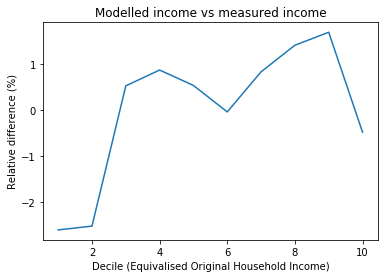

In [10]:
plot.plot(decile,100*(origEqMod/origIncomeEq - 1))
plot.xlabel(decLab)
plot.ylabel('Relative difference (%)')
plot.title('Modelled income vs measured income')

## Test taxable income
Can we accurately model the income

The measured "direct tax" is income tax, NI, student loan repayments and council tax (minus rebates).

Assume it is calculated based on original income + direct benefits (pension, DSA, child benefit etc.)

Model it with 2018/19 tax bands

In [11]:
# set tax badns and thresholds
tax20=11850
tax40=34500+tax20
tax45=150000+tax20
# calculate taxable income (total and in each tax band) for deciles
taxableInc=origIncome+dirBen
taxable20=np.maximum(0,np.where(taxableInc<tax40,taxableInc-tax20,tax40-tax20))
taxable40=np.maximum(0,np.where(taxableInc<tax45,taxableInc-tax40,tax45-tax40))
taxable45=np.maximum(0,taxableInc-tax45)
# calculate total tax paid
taxPaid=taxable20*0.2 + taxable40*0.4 + taxable45*0.45

In [12]:
# model the tax paid in more detail, using the income model above
dirTaxMod=np.zeros(10)
for q in range(10):
    narr=np.arange(q*0.1,(q+1)*0.1,0.01)
    tInc=model(narr,Eq=False)
    tInc=tInc + dirBen[q]
    t20=np.maximum(0,np.where(tInc<tax40,tInc-tax20,tax40-tax20))
    t40=np.maximum(0,np.where(tInc<tax45,tInc-tax40,tax45-tax40))
    t45=np.maximum(0,tInc-tax45)
    tPaid=t20*0.2 + t40*0.4 + t45*0.45
    dirTaxMod[q]=np.mean(tPaid)

136256.05
135789


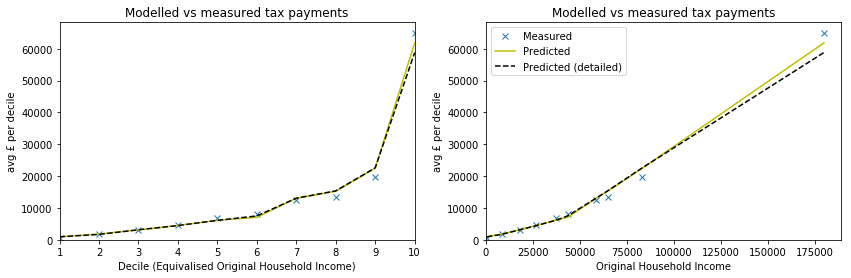

In [13]:
# plot the model vs the measure tax payments
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,data['DirectTax'],'x')
plot.plot(decile,taxPaid,'y-')
plot.plot(decile,dirTaxMod,'k--')
plot.xlim(1,10)
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.title('Modelled vs measured tax payments')

plot.subplot(1,2,2)
plot.plot(origIncome,data['DirectTax'],'x',label='Measured')
plot.plot(origIncome,taxPaid,'y-',label='Predicted')
plot.plot(origIncome,dirTaxMod,'k--',label='Predicted (detailed)')
plot.xlim(0,plot.xlim()[1])
plot.ylim(0,plot.ylim()[1])
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.legend()
plot.title('Modelled vs measured tax payments')


print(np.sum(taxPaid))
print(np.sum(data['DirectTax']))
totalBenefits=np.sum(dirBen)
totalDirectTax=np.sum(dirTax)
totalNetIncome=totalDirectTax-totalBenefits

This understimates tax paid in some bands, and overerestimates in others. How inaccurate is it, and how does the toal compare

Total Measured Tax: 135789
Total Modelled Tax: 133731.65262263658 (-1.5151060670329786%)


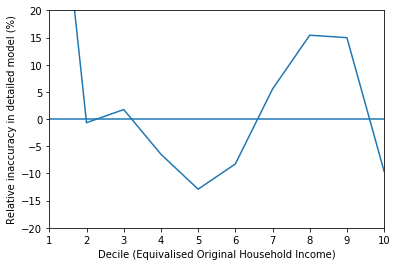

In [14]:
# calculate total tax paid
plot.plot(decile,100*(dirTaxMod/dirTax-1))
plot.xlabel(decLab)
plot.ylabel('Relative inaccuracy in detailed model (%)')
plot.ylim(-20,20)
plot.xlim(1,10)
plot.axhline(0)
totDirTax=np.sum(dirTax*nHouseholds)/1e9
totDirTaxMod=np.sum(dirTaxMod*nHouseholds)/1e9
print('Total Measured Tax: £{}bn'.format(inttotDirTax))
print('Total Modelled Tax: £{}bn (change {}%)'.format(totDirTaxMod,100*(totDirTaxMod/totDirTax-1)))

### The national picture
How does the nation do interms of tax and benefits

In [15]:
# calculate total benfits and tax and net national income
totalBenefits=np.sum(dirBen*nHouseholds)/1e9
totalDirectTax=np.sum(dirTax*nHouseholds)/1e9
totalNetIncome=totalDirectTax-totalBenefits
print('Total direct benefits: £{}bn'.format(int(totalBenefits)))
print('Total direct tax: £{}bn'.format(int(totalDirectTax)))
print('Net National Income: £{}bn'.format(int(totalNetIncome)))

Total direct benefits: £185bn
Total direct tax: £356bn
Net National Income: £170bn


### Plot incomes across deciles

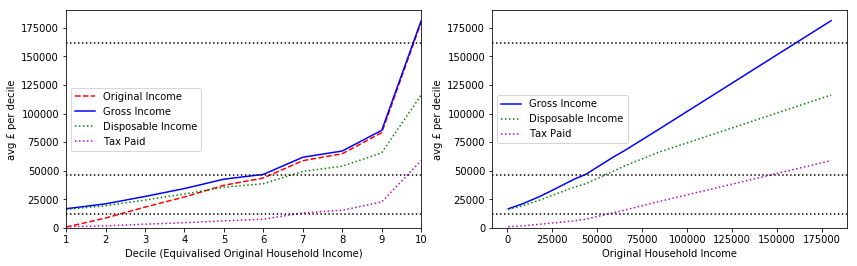

In [17]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,origIncome,'r--',label='Original Income')
plot.plot(decile,grossIncome,'b-',label='Gross Income')
plot.plot(decile,dispIncome,'g:',label='Disposable Income')
plot.plot(decile,dirTaxMod,'m:',label='Tax Paid')
plot.legend()
plot.xlim(1,10)
plot.ylim(0,plot.ylim()[1])
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(tax20,c='k',ls=':')
plot.axhline(tax40,c='k',ls=':')
plot.axhline(tax45,c='k',ls=':')

plot.subplot(1,2,2)
plot.plot(origIncome,grossIncome,'b-',label='Gross Income')
plot.plot(origIncome,dispIncome,'g:',label='Disposable Income')
plot.plot(origIncome,dirTaxMod,'m:',label='Tax Paid')
plot.legend()
plot.ylim(0,plot.ylim()[1])
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(tax20,c='k',ls=':')
plot.axhline(tax40,c='k',ls=':')
plot.axhline(tax45,c='k',ls=':')

## New model
Construct a new model, with uniform benefits, and different tax bands

In [18]:
# set out the benfits and tax thresholds
uniBen=17000
origNew=origIncome
dirBenNew=[uniBen]*len(dirBen)
grossNew=origNew+dirBenNew

# set tax thresholds (uniform across incomes)
taxPaidNew=np.zeros(10)
th1=0
th2=50000
th3=100000
tax1=0.48
tax2=0.48
tax3=0.48
for q in range(10):
    narr=np.arange(q*0.1,(q+1)*0.1,0.01)
    # calculate taxable income in each tax band
    tInc=model(narr,Eq=False)
    t1=np.maximum(0,np.where(tInc<th2,tInc-th1,th2-th1))
    t2=np.maximum(0,np.where(tInc<th3,tInc-th2,th3-th2))
    t3=np.maximum(0,tInc-th3)
    tPaidNew=t1*tax1 + t2*tax2 + t3*tax3
    taxPaidNew[q]=np.mean(tPaidNew)

# calculate disposable income
dispNew=grossNew-taxPaidNew
# calculate totan benefits and taxes, and compare with old model
totalBenefitsNew=np.sum(dirBenNew*nHouseholds)/1e9
totalDirectTaxNew=np.sum(taxPaidNew*nHouseholds)/1e9
totalNetIncomeNew=totalDirectTaxNew-totalBenefitsNew

print('Total direct benefits: £{}bn [change £{}bn]'.format(int(totalBenefitsNew),int(totalBenefitsNew-totalBenefits)/1e9))
print('Total direct tax: £{}bn [change £{}bn]'.format(int(totalDirectTaxNew),int(totalDirectTaxNew-totalDirectTax)))
print('Net National Income: £{}bn [change £{}bn]'.format(int(totalNetIncomeNew),int(totalNetIncomeNew-totalNetIncome)))

Total direct benefits: £468bn [change £2.82e-07bn]
Total direct tax: £644bn [change £287bn]
Net National Income: £176bn [change £5bn]


Text(0.5,1,'New model (by income)')

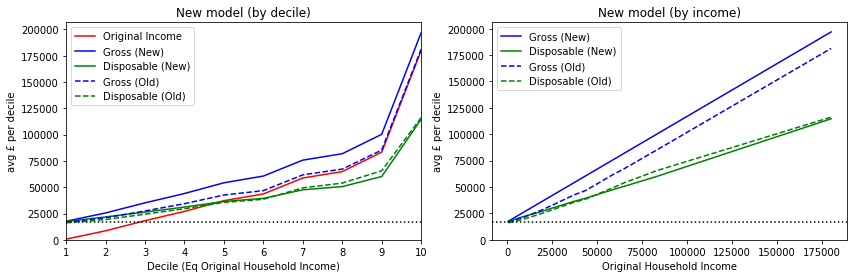

In [19]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.plot(decile,origIncome,'r-',label='Original Income')
plot.plot(decile,grossNew,'b-',label='Gross (New)')
plot.plot(decile,dispNew,'g-',label='Disposable (New)')
plot.plot(decile,grossIncome,'b--',label='Gross (Old)')
plot.plot(decile,dispIncome,'g--',label='Disposable (Old)')
plot.legend()
plot.xlim(1,10)
plot.xlabel('Decile (Eq Original Household Income)')
plot.ylabel('avg £ per decile')
plot.ylim(0,plot.ylim()[1])
plot.axhline(uniBen,c='k',ls=':')
plot.title('New model (by decile)')

plot.subplot(1,2,2)
plot.plot(origIncome,grossNew,'b-',label='Gross (New)')
plot.plot(origIncome,dispNew,'g-',label='Disposable (New)')
plot.plot(origIncome,grossIncome,'b--',label='Gross (Old)')
plot.plot(origIncome,dispIncome,'g--',label='Disposable (Old)')
plot.legend()
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.ylim(0,plot.ylim()[1])
plot.axhline(uniBen,c='k',ls=':')
plot.title('New model (by income)')


### Compare the models
Compare benefits and taxes

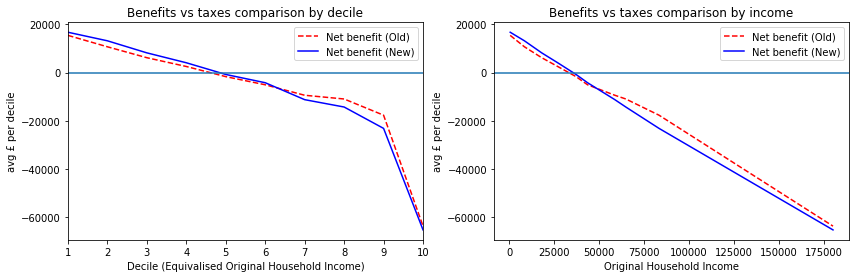

In [20]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.title('Benefits vs taxes comparison by decile')
plot.plot(decile,dirBen-dirTax,'r--',label='Net benefit (Old)')
plot.plot(decile,dirBenNew-taxPaidNew,'b-',label='Net benefit (New)')
plot.xlim(1,10)
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(0)
plot.legend()

plot.subplot(1,2,2)
plot.title('Benefits vs taxes comparison by income')
plot.plot(origIncome,dirBen-dirTax,'r--',label='Net benefit (Old)')
plot.plot(origIncome,dirBenNew-taxPaidNew,'b-',label='Net benefit (New)')
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(0)
plot.legend()

Those in deciles 0-5 are net beneficiaries, 6-10 are net contributors, and similar to current system

### Plot change across deciles
How does the change affect each decile

Text(0.5,0,'Decile (Equivalised Original Household Income)')

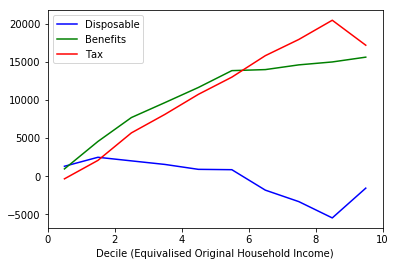

In [21]:
plot.plot(decile-0.5,dispNew-dispIncome,'b-',label='Disposable')
plot.plot(decile-0.5,dirBenNew-dirBen,'g-',label='Benefits')
plot.plot(decile-0.5,taxPaidNew-dirTax,'r-',label='Tax')
plot.legend()
plot.xlim(0,10)
plot.xlabel(decLab)



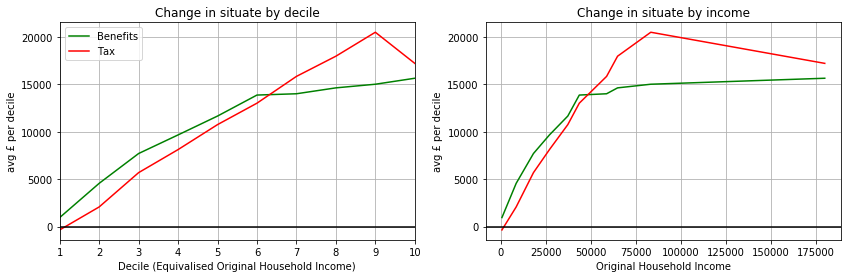

In [22]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.title('Change in situate by decile')
plot.plot(decile,dirBenNew-dirBen,'g-',label='Benefits')
plot.plot(decile,taxPaidNew-dirTax,'r-',label='Tax')
plot.legend()
plot.xlim(1,10)
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(0,c='k')
plot.grid()

plot.subplot(1,2,2)
plot.title('Change in situate by income')
plot.plot(origIncome,dirBenNew-dirBen,'g-',label='Benefits')
plot.plot(origIncome,taxPaidNew-dirTax,'r-',label='Tax')
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(0,c='k')
plot.grid()

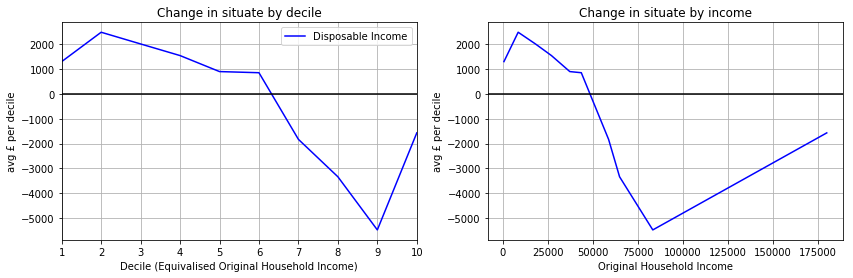

In [23]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.title('Change in situate by decile')
plot.plot(decile,dispNew-dispIncome,'b-',label='Disposable Income')
plot.legend()
plot.xlim(1,10)
plot.xlabel(decLab)
plot.ylabel('avg £ per decile')
plot.axhline(0,c='k')
plot.grid()

plot.subplot(1,2,2)
plot.title('Change in situate by income')
plot.plot(origIncome,dispNew-dispIncome,'b-',label='Disposable Income')
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(0,c='k')
plot.grid()

Those in deciles 1-6 benefit at a few £k/year. Those in higher deciles suffer more

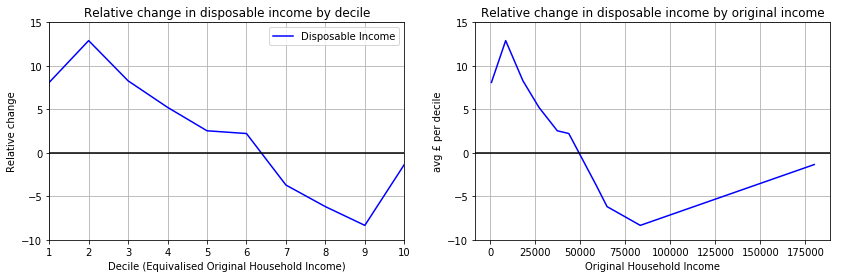

In [24]:
plot.figure(figsize=(14,4))
plot.subplot(1,2,1)
plot.title('Relative change in disposable income by decile')
plot.plot(decile,100*(dispNew/dispIncome-1),'b-',label='Disposable Income')
plot.legend()
plot.xlim(1,10)
plot.xlabel(decLab)
plot.ylabel('Relative change')
plot.axhline(0,c='k')
plot.ylim(-10,15)
plot.grid()

plot.subplot(1,2,2)
plot.title('Relative change in disposable income by original income')
plot.plot(origIncome,100*(dispNew/dispIncome-1),'b-',label='Disposable Income')
plot.xlabel('Original Household Income')
plot.ylabel('avg £ per decile')
plot.axhline(0,c='k')
plot.ylim(-10,15)
plot.grid()

Relative changes are at the ~10% level max.